In [1]:
import os
import pandas as pd

In [2]:
os.getcwd()

'C:\\Users\\USER\\Desktop\\Machine_Learning'

In [3]:
# 마스크를 끼고 있거나 끼고 있지 않은 다양한 사진을 수집하여 Face Mask Detection이라는 파일을 생성하였습니다.

In [4]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\annotations')))
print(len(os.listdir('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\images')))

# 위의 py파일을 이용해 모은 Face mask Detection파일의 폴더별 수입니다.
# images 폴더에는 0부터 852번까지의 이미지 파일이 있으며
# annotations 폴더에는 이미지 파일의 정보를 가지고 있는 xml 파일이 0부터 852번까지 있습니다.

683
683


In [7]:
random.seed(1234)
idx = random.sample(range(853), 170)

# 전체 데이터셋 개수가 853개로 조금 적다고 생각해 8대 2의 비율로 시험 데이터를 만듭니다.
# 853개의 데이터 중에서 170개를 시험 데이터로 사용하기 위해 이들을 별도의 폴더 
# test_images와 test_annotations 폴더에 랜덤하게 옮겨주겠습니다.

In [8]:
for img in np.array(sorted(os.listdir('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\images')))[idx]:
    shutil.move('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\images/'+img, 'C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\test_images/'+img)

for annot in np.array(sorted(os.listdir('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\annotations')))[idx]:
    shutil.move('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\annotations/'+annot, 'C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\test_annotations/'+annot)

print(len(os.listdir('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\annotations')))
print(len(os.listdir('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\images')))
print(len(os.listdir('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\test_annotations')))
print(len(os.listdir('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\test_images')))

683
683
170
170


In [9]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models import ResNet50_Weights
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt

img_list = sorted(glob.glob('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\images\\*'))
annot_list = sorted(glob.glob('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\annotations\\*'))


def generate_box(obj):  ## xmin, ymin, xmax, ymax 값 반환

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]


def generate_label(obj):  # 마스크 착용 여부 반환, 0:without mask, 1:with mask, 2:mask_weared_incorrect

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0


def generate_target(file):  # 위의 두 generate를 각각 호출하여 반환된 값을 저장하고 반환
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")  # annotations를 불러와 target의 바운딩 박스와 라벨 추출
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target


def plot_image_from_output(img, annotation):  # 바운딩 박스 시각화
    # with mask - 빨간색, with mask - 초록색, mask_weared_incorrect - 주황색

    img = img.cpu().permute(1, 2, 0)

    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0:
            rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1, edgecolor='r',
                                     facecolor='none')

        elif annotation['labels'][idx] == 1:

            rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1, edgecolor='g',
                                     facecolor='none')

        else:

            rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1, edgecolor='orange',
                                     facecolor='none')

        rects.append(rect)

    return img, rects


class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join(
                "C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\test_annotations/", file_label)
        else:
            label_path = os.path.join("C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\annotations/",
                                      file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)

        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)

        # tensor로 변경
        img = to_tensor(img)

        return img, target


def collate_fn(batch):
    return tuple(zip(*batch))


dataset = MaskDataset('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\images/')
test_dataset = MaskDataset('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\test_images/')

# 훈련용 데이터와 시험용 데이터를 불러올 수 있게 torch.utils.data.DataLoader 함수를 활용해 각각을 정의
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

weights_backbone = ResNet50_Weights.IMAGENET1K_V1

In [10]:
retina = retinanet_resnet50_fpn(num_classes=3, weights=None, weights_backbone=weights_backbone)

torchvision.models 모듈을 통해 RetinaNet모델을 불러옴
Face Mask Detection 데이터셋에 3개의 클래스가 존재하므로 num_classes의 매개변수를 3으로 정의하고
전이학습을 진행하기에 backbone 구조는 사전학습된 가중치를, 그 외 가중치는 초기화시키고 가져옵니다.

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 1
retina.to(device)
    
# parameters
params = [p for p in retina.parameters() if p.requires_grad] # gradient calculation이 필요한 params만 추출
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

In [13]:
for epoch in range(num_epochs):
    start = time.time()
    if torch.cuda.is_available():
        torch.cuda.synchronize()  # GPU 시간 측정을 위한 동기화

    retina.train()
    epoch_loss = 0

    for i, (images, targets) in enumerate(data_loader, 1):
        # 데이터 전송
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # 손실 계산
        loss_dict = retina(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # 그래디언트 초기화, 역전파, 가중치 업데이트
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # 손실 값 누적
        epoch_loss += losses.item()

        # 진행 상황 출력
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(data_loader)}], Loss: {losses.item():.4f}')
    
    # 에포크 손실 출력
    print(f'Epoch {epoch+1}/{num_epochs}, Total Loss: {epoch_loss:.4f}, Time: {time.time() - start:.2f}s')

Epoch [1/1], Step [1/171], Loss: 1.7942
Epoch [1/1], Step [2/171], Loss: 1.8140
Epoch [1/1], Step [3/171], Loss: 1.8205
Epoch [1/1], Step [4/171], Loss: 1.7948
Epoch [1/1], Step [5/171], Loss: 1.7772
Epoch [1/1], Step [6/171], Loss: 1.7936
Epoch [1/1], Step [7/171], Loss: 1.7576
Epoch [1/1], Step [8/171], Loss: 1.7745
Epoch [1/1], Step [9/171], Loss: 1.7319
Epoch [1/1], Step [10/171], Loss: 1.7740
Epoch [1/1], Step [11/171], Loss: 1.7834
Epoch [1/1], Step [12/171], Loss: 1.7296
Epoch [1/1], Step [13/171], Loss: 1.7084
Epoch [1/1], Step [14/171], Loss: 1.7074
Epoch [1/1], Step [15/171], Loss: 1.7260
Epoch [1/1], Step [16/171], Loss: 1.7270
Epoch [1/1], Step [17/171], Loss: 1.7009
Epoch [1/1], Step [18/171], Loss: 1.6518
Epoch [1/1], Step [19/171], Loss: 1.6969
Epoch [1/1], Step [20/171], Loss: 1.6886
Epoch [1/1], Step [21/171], Loss: 1.6898
Epoch [1/1], Step [22/171], Loss: 1.7076
Epoch [1/1], Step [23/171], Loss: 1.6733
Epoch [1/1], Step [24/171], Loss: 1.6790
Epoch [1/1], Step [25/171

In [14]:
torch.save(retina.state_dict(),f'retina_{num_epochs}.pt')
# 학습된 가중치 저장

In [15]:
retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))

C:\Users\USER\AppData\Local\Temp\ipykernel_24504\994584243.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))


<All keys matched successfully>

In [16]:
def make_prediction(model, img, threshold):
    model.eval()
    with torch.no_grad():  # 그래디언트 비활성화
        preds = model(img)  # 모델 예측 수행
        
    for id in range(len(preds)) :
        if 'scores' not in preds[id] or len(preds[id]['scores']) == 0:
                continue  # 스코어가 없는 경우 건너뜁니다

        # 신뢰도 threshold 넘는 바운딩 박스 필터링
        mask = preds[id]['scores'] > threshold
        preds[id]['boxes'] = preds[id]['boxes'][mask]
        preds[id]['labels'] = preds[id]['labels'][mask]
        preds[id]['scores'] = preds[id]['scores'][mask]

    return preds

In [17]:
from tqdm import tqdm # 진행상황 나타내기

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position=0, leave=True):
    # 테스트 데이터 배치 처리
    im = [img.to(device) for img in im]  # 이미지를 GPU로 이동

    # 레이블 누적
    for t in annot:
        labels.extend(t['labels'])  # 효율적으로 리스트 확장

    with torch.no_grad():  # 예측 수행 (그래디언트 계산 비활성화)
        try:
            preds_adj = make_prediction(retina, im, 0.5)  # 예측
            preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]  # CPU로 이동
            preds_adj_all.append(preds_adj)
            annot_all.append([{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in annot])  # 주석도 CPU로 이동
        except Exception as e:
            print(f"Error during prediction: {e}")
            continue


00%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [04:49<00:00,  3.41s/it]

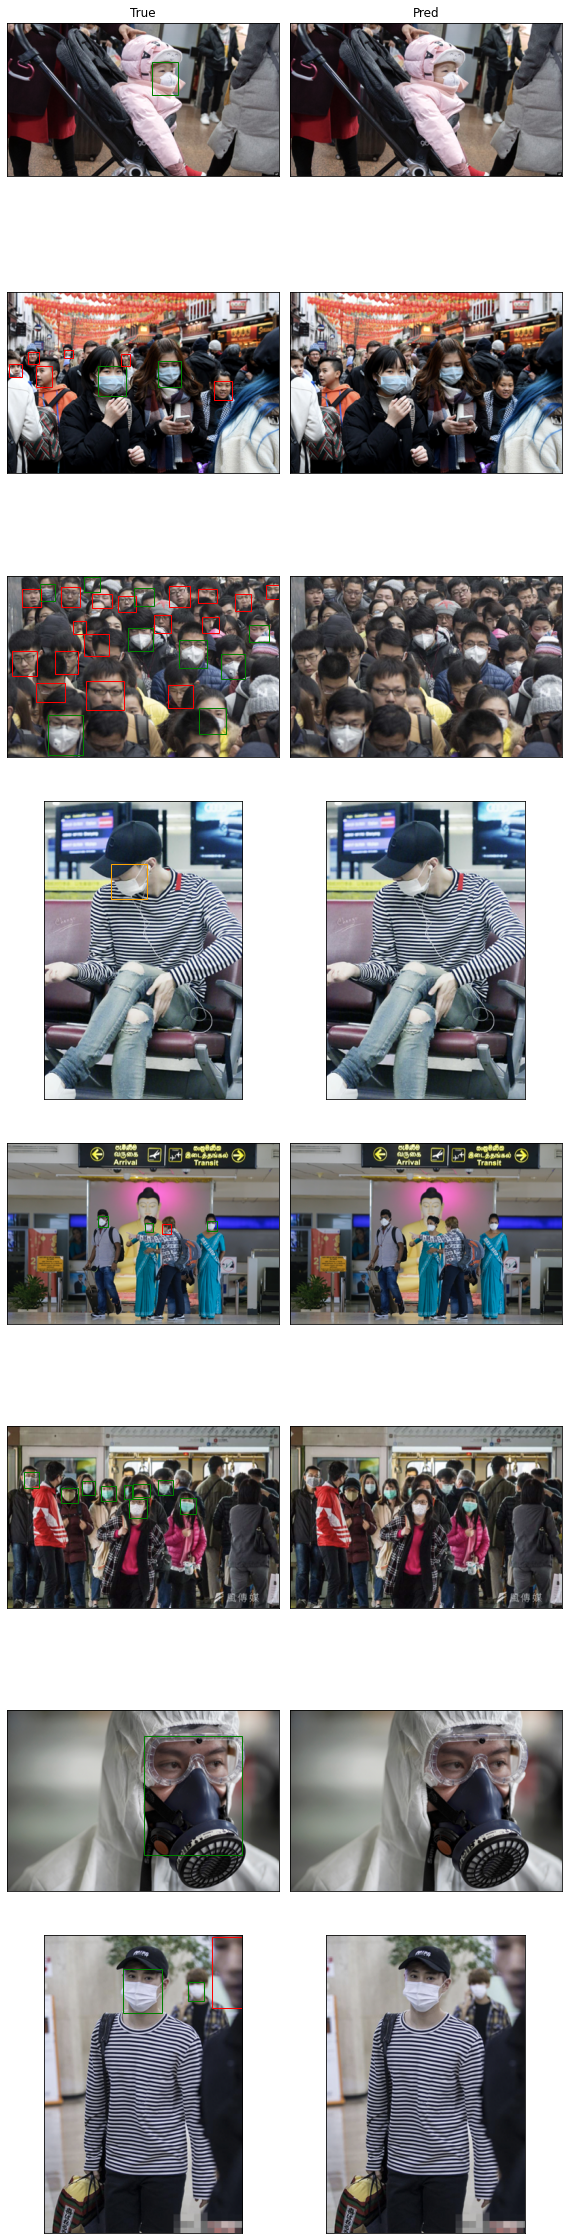

In [19]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_data_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        
        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
        
        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# xtick, ytick 제거
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

# 실제 바운딩 박스와 예측한 바운딩 박스에 대한 시각화

# 바운딩 박스 도식화

In [20]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup

In [21]:
img_list = sorted(glob.glob('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\images\\*'))
annot_list = sorted(glob.glob('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\annotations\\*'))
# glob을 이용해 데이터셋을 불러온다.

def generate_box(obj): ## xmin, ymin, xmax, ymax 값 반환
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj): # 마스크 착용 여부 반환, 0:without mask, 1:with mask, 2:mask_weared_incorrect
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(file): # 위의 두 generate를 각각 호출하여 반환된 값을 저장하고 반환
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser") # annotations를 불러와 target의 바운딩 박스와 라벨 추출
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image(img_path, annotation): # 바운딩 박스 시각화
    # without mask - 빨간색, with mask - 초록색, mask_weared_incorrect - 주황색
    
    img = mpimg.imread(img_path)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [22]:
img_list.index('C:\\Users\\USER\\Desktop\\Machine_Learning\\Face mask Detection\\images\\maksssksksss759.png')

580

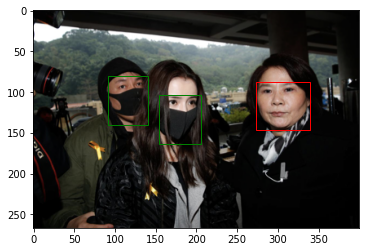

In [23]:
bbox = generate_target(annot_list[580])
plot_image(img_list[580], bbox)

# 미리 훈련된 모델들을 이용해 사진에서 얼굴 검출 및 마스크 착용 여부 확인

In [24]:
from keras.applications.mobilenet_v2 import preprocess_input
from keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

plt.style.use('dark_background') # 배경을 검은 색상으로

In [33]:
# OpenCV DNN 기반 Face Detector 로드
facenet = cv2.dnn.readNet('models/deploy.prototxt', 'models/res10_300x300_ssd_iter_140000.caffemodel')

# Keras 3에서 Mask Detector 모델 로드
model = load_model('models/mask_detector_model.h5')  # .h5 형식의 모델 파일
# .h5 파일이 없는 경우 SavedModel 디렉터리를 사용
# model = load_model('models/mask_detector_model')  # SavedModel 디렉터리

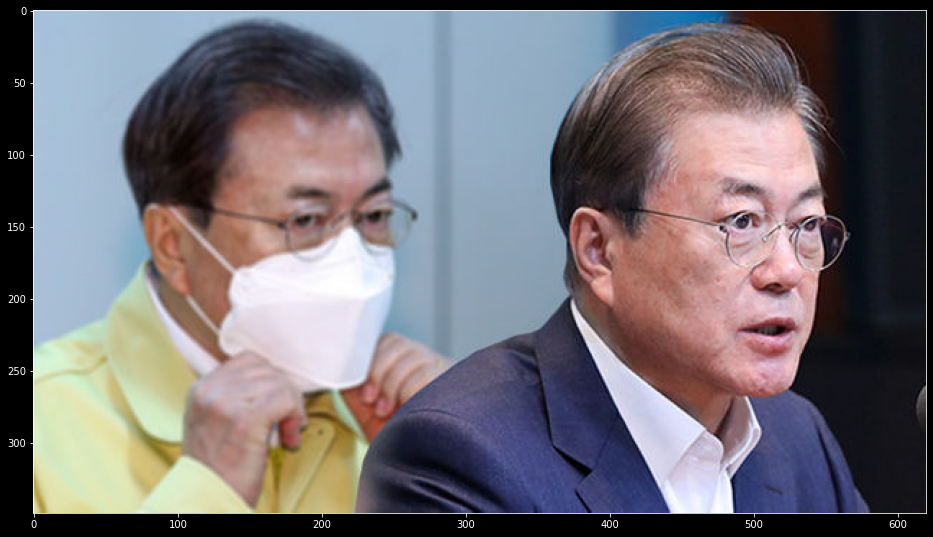

In [26]:
img = cv2.imread('imgs/01.jpg') # open cv의 imread를 사용해 test image 불러옴
h, w = img.shape[:2]

plt.figure(figsize=(16, 10))
plt.imshow(img[:, :, ::-1]) # RGB로 불러들임

In [27]:
blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))
# dnn 모듈이 사용하는 형태로 이미지 변형
facenet.setInput(blob) 
dets = facenet.forward() # inference 후 face detection 결과 저장

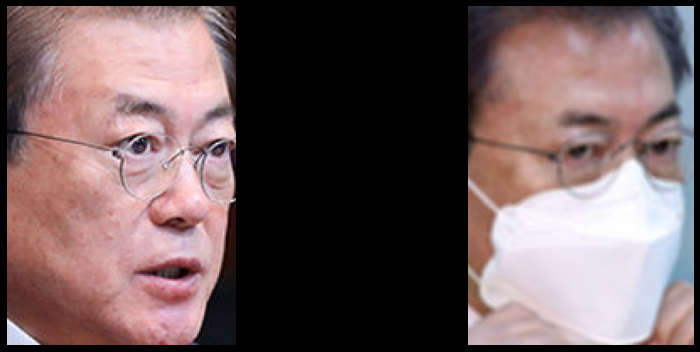

In [28]:
# 얼굴 추출
faces = []
threshold = 0.5  # 신뢰도 임계값

for i in range(dets.shape[2]):
    confidence = dets[0, 0, i, 2]
    if confidence < threshold:
        continue

    # 바운딩 박스 좌표 계산
    x1 = int(dets[0, 0, i, 3] * w)
    y1 = int(dets[0, 0, i, 4] * h)
    x2 = int(dets[0, 0, i, 5] * w)
    y2 = int(dets[0, 0, i, 6] * h)

    # 경계 처리
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    # 얼굴 추출
    face = img[y1:y2, x1:x2]
    faces.append(face)

# 시각화
plt.figure(figsize=(16, 5))

for i, face in enumerate(faces):
    face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)  # BGR -> RGB
    plt.subplot(1, len(faces), i + 1)
    plt.imshow(face_rgb)
    plt.axis("off")  # 축 숨기기

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


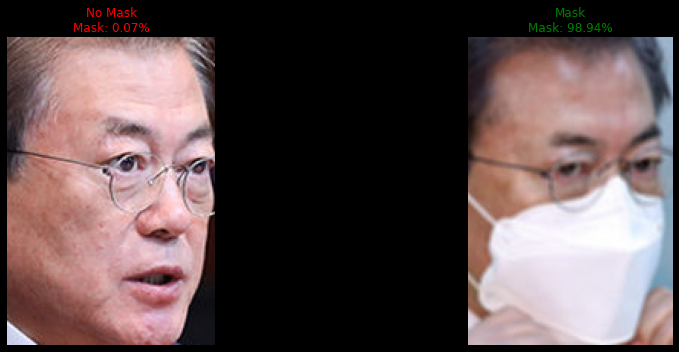

In [29]:
# 얼굴에서 마스크 찾기
plt.figure(figsize=(16, 5))

for i, face in enumerate(faces):  # 얼굴 개수만큼 반복
    # 전처리
    try:
        face_input = cv2.resize(face, dsize=(224, 224))  # 크기 조정
        face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)  # BGR -> RGB
        face_input = preprocess_input(face_input)  # 정규화
        face_input = np.expand_dims(face_input, axis=0)  # 배치 차원 추가

        # 예측 수행
        mask, nomask = model.predict(face_input).squeeze()

        # 라벨 및 색상 설정
        label = "Mask" if mask > nomask else "No Mask"
        color = "green" if mask > nomask else "red"

        # 얼굴 시각화
        plt.subplot(1, len(faces), i + 1)
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환
        plt.imshow(face_rgb)
        plt.title(f"{label}\nMask: {mask*100:.2f}%", color=color)
        plt.axis("off")
    except Exception as e:
        print(f"Error processing face {i}: {e}")

plt.tight_layout()
plt.show()

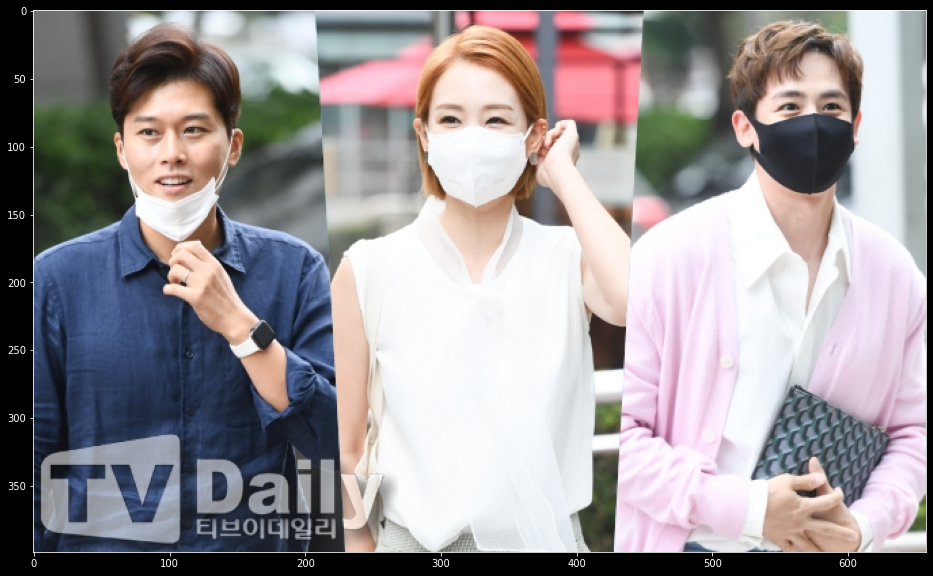

In [30]:
img = cv2.imread('imgs/02.jpg') # open cv의 imread를 사용해 test image 불러옴
h, w = img.shape[:2]

plt.figure(figsize=(16, 10))
plt.imshow(img[:, :, ::-1]) # RGB로 불러들임

In [31]:
blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))
# dnn 모듈이 사용하는 형태로 이미지 변형
facenet.setInput(blob) 
dets = facenet.forward() # inference 후 face detection 결과 저장

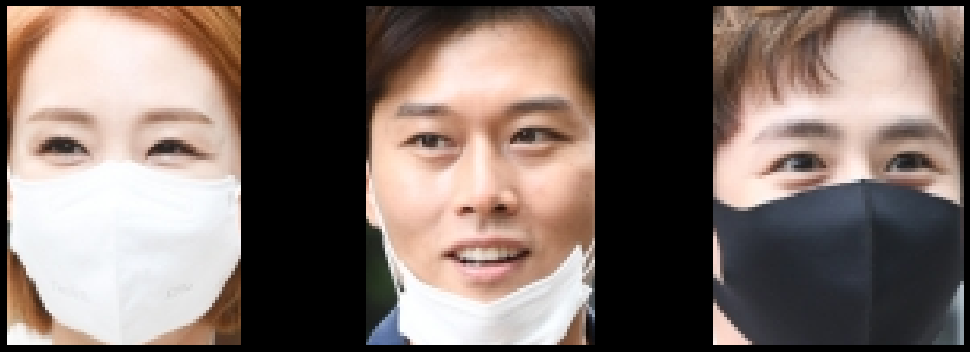

In [32]:
# 얼굴 추출
faces = []
threshold = 0.5  # 신뢰도 임계값

for i in range(dets.shape[2]):
    confidence = dets[0, 0, i, 2]
    if confidence < threshold:
        continue

    # 바운딩 박스 좌표 계산
    x1 = int(dets[0, 0, i, 3] * w)
    y1 = int(dets[0, 0, i, 4] * h)
    x2 = int(dets[0, 0, i, 5] * w)
    y2 = int(dets[0, 0, i, 6] * h)

    # 경계 처리
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    # 얼굴 추출
    face = img[y1:y2, x1:x2]
    faces.append(face)

# 시각화
plt.figure(figsize=(16, 5))

for i, face in enumerate(faces):
    face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)  # BGR -> RGB
    plt.subplot(1, len(faces), i + 1)
    plt.imshow(face_rgb)
    plt.axis("off")  # 축 숨기기

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


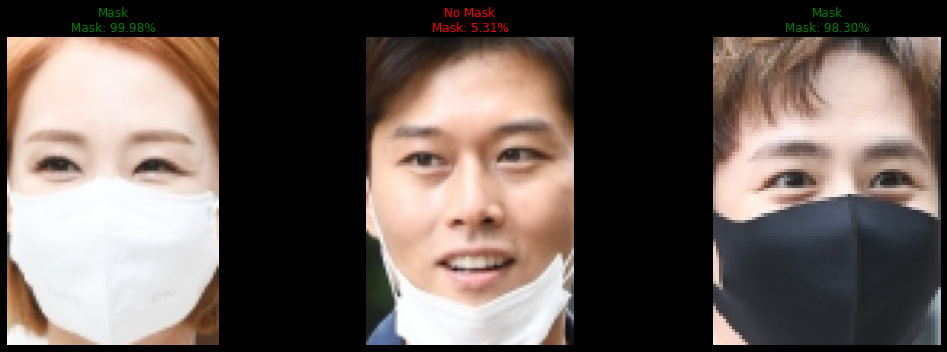

In [34]:
# 얼굴에서 마스크 찾기
plt.figure(figsize=(16, 5))

for i, face in enumerate(faces):  # 얼굴 개수만큼 반복
    # 전처리
    try:
        face_input = cv2.resize(face, dsize=(224, 224))  # 크기 조정
        face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)  # BGR -> RGB
        face_input = preprocess_input(face_input)  # 정규화
        face_input = np.expand_dims(face_input, axis=0)  # 배치 차원 추가

        # 예측 수행
        mask, nomask = model.predict(face_input).squeeze()

        # 라벨 및 색상 설정
        label = "Mask" if mask > nomask else "No Mask"
        color = "green" if mask > nomask else "red"

        # 얼굴 시각화
        plt.subplot(1, len(faces), i + 1)
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환
        plt.imshow(face_rgb)
        plt.title(f"{label}\nMask: {mask*100:.2f}%", color=color)
        plt.axis("off")
    except Exception as e:
        print(f"Error processing face {i}: {e}")

plt.tight_layout()
plt.show()